In [17]:
import numpy as np                                                                        
import matplotlib.pyplot as plt
import pyCloudy as pc
import pyneb as pn
from astropy    import constants as const
from astropy.io import ascii
import pandas as pd
from scipy import interpolate
import warnings
from scipy.integrate import quad, IntegrationWarning
# from scipy.integrate import simps
from numpy import log10, exp

kpc = const.kpc.cgs.value

atom = ['Lya','HeII','CIV']

def read_file(path_way, atom):
    Mod = pc.CloudyModel(path_way, cloudy_version_major=23)
    Mod.ionic_names

    N_H = sum(Mod.dr*Mod.nH)
    # solar_metallicitiy from von Steiger et al. 2016
    frac_He = 1.0E-01
    frac_C = 4.47E-04
    frac_O = 6.61E-04
    frac_N = 9.33E-05
    frac_Mg = 7.08E-05

    N_HI = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',0))
    N_HII = sum(Mod.dr*Mod.nH*Mod.get_ionic('H',1))
    N_HeII = frac_He*sum(Mod.dr*Mod.nH*Mod.get_ionic('He',1))
    N_OVI = frac_O*sum(Mod.dr*Mod.nH*Mod.get_ionic('O',5))
    N_NV = frac_N*sum(Mod.dr*Mod.nH*Mod.get_ionic('N',4))
    N_CIV = frac_C*sum(Mod.dr*Mod.nH*Mod.get_ionic('C',3))

    num = len(Mod.nH)
    r_CIV = path_way +  '.ele_C'
    f = open(r_CIV,'r')
    header = f.readline()
    CIV_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[4])
        CIV_frac[i] = j
        i = i + 1

    r_He = path_way +  '.ele_He'
    f = open(r_He,'r')
    header = f.readline()
    HeII_frac = np.zeros(num)
    i = 0
    for line in f:
        line = line.strip()
        columns = line.split()
        j = float(columns[2])
        HeII_frac[i] = j
        i = i + 1



    n_H= Mod.nH
    n_He = n_H*frac_He
    n_C = n_H*frac_C
    nden_CIV = CIV_frac*n_C
    nden_HeII = HeII_frac*n_He

    # tt = nden_CIV / n_H
    # print(tt.mean())

    if atom == 'CIV':
        Cloudy_Lum = float(Mod.get_emis_vol('C__4_154819A')) + float(Mod.get_emis_vol('C__4_155078A'))
        Cloudy_emis = (Mod.get_emis('C__4_154819A')) + (Mod.get_emis('C__4_155078A'))
        Cloudy_den = nden_CIV
    elif atom == 'Lya':
        Cloudy_Lum= float(Mod.get_emis_vol('H__1_121567A'))
        Cloudy_emis = Mod.get_emis('H__1_121567A')
        Cloudy_den = n_H
    elif atom == 'HeII':
        Cloudy_Lum = float(Mod.get_emis_vol('HE_2_164043A'))
        Cloudy_emis = Mod.get_emis('HE_2_164043A')
        Cloudy_den = nden_HeII
    return Cloudy_Lum , Cloudy_emis ,Cloudy_den

def radius(path, atom):
    Mod = pc.CloudyModel(path, cloudy_version_major=23)
    radius = Mod.radius/kpc
    radius_kpc =Mod.radius 
    dr = Mod.dr 
    return radius, radius_kpc, dr

def make_data_file(path,atom):
    lum ,emis ,den = read_file(path,atom)
    radius_R , radius_kpc , dr=  radius(path,atom)
    tt =  pd.DataFrame(np.column_stack((radius_R,emis,den)))
    tt.to_csv('/home/jin/T_Cloudy/CIV_cloudy.txt', sep='\t',index=False,header =False)
    tt.to_csv('/home/jin/RT_code/CIV_cloudy.txt', sep='\t',index = False,header=False)
    return print("make data file!")


# def SB(z,radius_kpc, emissivity,dr,aa):
#     r_min, r_max = radius_kpc.min(), radius_kpc.max()  
#     Project_R  = np.linspace(0,100,300) * kpc
#     N = len(Project_R )
#     surface_brightness = np.zeros(N)
#     Lumin = np.zeros(N)
#     T_Lumin = np.zeros(N)
#     dR_pro = Project_R[1] -Project_R[0] 
#     for ii, bb in enumerate(Project_R):
#         array_R = np.where(radius_kpc >= bb)[0]
#         r_surface_brightness = 0
#         for dR in (array_R):
#             r_surface_brightness += emissivity[dR] * dr[dR] 
#         surface_brightness[ii] = 2*r_surface_brightness / (1+z)**4 
#         Lumin[ii] = 4*np.pi*bb*surface_brightness[ii] * dR_pro * (1+z)**4

#     return Project_R/ kpc, surface_brightness ,Lumin


import numpy as np
import scipy.integrate as integrate

def SB(z, radius_kpc, emissivity, dr):
    """ 
    Surface Brightness 계산 함수 (적분을 활용한 방식) 
    """
    r_min, r_max = radius_kpc.min(), radius_kpc.max()  
    Project_R = np.linspace(0, 100, 300) * kpc
    N = len(Project_R)
    surface_brightness = np.zeros(N)
    Lumin = np.zeros(N)
    T_Lumin = np.zeros(N)
    dR_pro = Project_R[1] - Project_R[0]

    # 적분 함수 정의 (j(r) * dr 부분을 적분)
    def integrand(r):
        return np.interp(r, radius_kpc, emissivity)  # 선형 보간을 이용하여 j(r) 값 추정

    for ii, bb in enumerate(Project_R):
        # 적분 수행: R ~ r_max 범위에서 j(r) dr 적분
        r_surface_brightness, _ = integrate.quad(integrand, bb, r_max)
        
        # 적분 결과를 표면 밝기 계산에 적용
        surface_brightness[ii] = 2 * r_surface_brightness / (1 + z) ** 4

        Lumin[ii] = 4 * np.pi * bb * surface_brightness[ii] * dR_pro * (1 + z) ** 4

    return Project_R / kpc, surface_brightness, Lumin


# def SB(z, radius_kpc, emissivity, dr,aa):
#     r_min, r_max = radius_kpc.min(), radius_kpc.max()
#     Project_R = np.linspace(0, 100, 300) * kpc
#     N = len(Project_R)
#     surface_brightness = np.zeros(N)
#     Lumin = np.zeros(N)

#     from scipy.interpolate import interp1d
#     emis_interp = interp1d(radius_kpc, emissivity, bounds_error=False, fill_value=0)
    
#     for ii, R in enumerate(Project_R):
#         # 적분 함수 정의
#         def integrand(r):
#             if r < R:
#                 return 0
#             else:
#                 emis = emis_interp(r)
#                 return emis * r / np.sqrt(r**2 - R**2)
            
#         surface_brightness[ii], _ = quad(integrand, R, r_max)
#         surface_brightness[ii] *= 2 / (1+z)**4
    
#     def lumin_integrand(R):
#         return 2 * np.pi * R * np.interp(R, Project_R, surface_brightness)
    
#     Lumin, _ = quad(lumin_integrand, 0, r_max)
    
#     return Project_R / kpc, surface_brightness, Lumin

def RT_SB(path):
    name = ['radius','SB_K','SB_H','SB_tot','1','2','3']
    data_sp = pd.read_csv(path, sep='\s+', header=None,names=name)
    rad, SB_t, SB_k,SB_h =  data_sp['radius'].to_numpy(),data_sp['SB_tot'].to_numpy(),data_sp['SB_K'].to_numpy(),data_sp['SB_H'].to_numpy()
    return rad*100, rad*100*kpc, SB_t 

def find_y(x_find,x,y):
    ii = int(np.where(x <= x_find)[0][-1])
    # print(ii)
    y_find = (y[ii+1] -y[ii]) / (x[ii+1] - x[ii])*(x_find - x[ii]) + y[ii]
    return y_find

warnings.filterwarnings("ignore", category=IntegrationWarning)

In [18]:
path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42'
# make_data_file(path_LT ,'Lya')

In [19]:
import numpy as np  # np.sum 사용을 위해 필요

def calculate_order_and_value(value):
    """ 주어진 값에 대해 변환된 값과 해당 order 반환 """

    if value == 0 :
        return "000" , 0
    elif value == 1:
        return int(value * 100), 0
    elif value < 100:
        return int(value * 10), 1
    elif value < 1000:
        return int(value), 2

    return int(value / 10), 3


def RT_make_parameter(v_out, v_emit, v_rand, atom):
    # 기본값 설정
    radius_RT, radius_kpc_RT, SB_RT = np.array([0]), np.array([0]), np.array([0])
    radius_CL, sb_CL = np.array([0]), np.array([0])
    normal_RT, normal_CL = 1, 1  # ZeroDivisionError 방지

    if v_out == 0:
        expand, vout_order = "000", 0
    else:
        expand, vout_order = v_out, 2
    # print(v_emit)
    emit, emit_order = calculate_order_and_value(v_emit)    
    # print(emit,emit_order)
    rand, rand_order = calculate_order_and_value(v_rand)
    # print(rand)

    # 파일 경로 설정
    #ubuntu
    path_rt = (f'/home/jin/T_Cloudy/sb_cloudy/data_RT/N_atom000E+00_'
                f'Vexp{expand}E+0{vout_order}_Vemit{emit}E+0{emit_order}_'
                f'tauD000E+00_Vran{rand}E+0{rand_order}radi.dat')
    #window
    # path_rt = (f'/home/jin/T_Cloudy/sb_cloudy/data_RT/N_atom000E+00_'
    #             f'Vexp{expand}E+0{vout_order}_Vemit{emit}E+0{emit_order}_'
    #             f'tauD000E+00_Vran{rand}E+0{rand_order}radi.dat')


    # RT_SB 함수 호출
    rt_output = RT_SB(path_rt)
    if rt_output is not None:
        radius_RT, radius_kpc_RT, SB_RT = rt_output

    # SB_RT 값이 None이거나 비어있을 경우 기본값 설정
    if SB_RT is None or len(SB_RT) == 0:
        SB_RT = np.array([0])
    normal_RT = np.sum(SB_RT) if np.sum(SB_RT) != 0 else 1

    print(f"make parameters of v_rand = {v_rand} km/s, v_exp = {v_out} km/s, v_emit = {v_emit} km/s for {atom}")

    # 추가 데이터 처리
    z_red_Shift = 0
    radius_data = radius(path_LT, atom)
    lum_data = read_file(path_LT, atom)
    sb_data = SB(z_red_Shift, radius_data[1], lum_data[1], radius_data[2])

    if sb_data is not None:
        radius_CL, sb_CL = sb_data[0], sb_data[1]

    # sb_CL 값이 None이거나 비어있을 경우 기본값 설정
    if sb_CL is None or len(sb_CL) == 0:
        sb_CL = np.array([0])
    normal_CL = np.sum(sb_CL) if np.sum(sb_CL) != 0 else 1

    return radius_RT, radius_kpc_RT, SB_RT / normal_RT, radius_CL, sb_CL 

In [20]:
# RT_path_LT =r'/home/jin/T_Cloudy/OTS_n_LT_y/data_RT/N_atom000E+00_Vexp000E+00_Vemit000E+00_tauD000E+00_Vran000E+00radi.dat'
RT_path_LT= r'/home/jin/RT_code/data_test/N_atom000E+00_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran118E+01radi.dat'
path_LT = r'/home/jin/T_Cloudy/OTS_n_LT_y/CIV_Lumin_42' # no OTS , yes LT

cloudy_model = ['LT'] # or - original (no LT, no Diffuse OTS) , n - no LT (on OTS), y - on LT , OTS, LT- no OTS (on LT)
atom_N = 'CIV'
def make_parameter(path,RT_path,atom,cloudy_index):
    z_red_Shift = 0
    globals()['radius_{}'.format(cloudy_index)] , globals()['radius_kpc_{}'.format(cloudy_index)], globals()['dr_{}'.format(cloudy_index)] = radius(path,atom)
    globals()['civ_lum_{}'.format(cloudy_index)] , globals()['civ_emis_{}'.format(cloudy_index)] , globals()['civ_den_{}'.format(cloudy_index)] = read_file(path,atom)
    globals()['rt_radius_{}'.format(cloudy_index)] , globals()['rt_radius_kpc_{}'.format(cloudy_index)], globals()['rt_sb_t_{}'.format(cloudy_index)] = RT_SB(RT_path)
    globals()['p_radius_{}'.format(cloudy_index)] , globals()['sb_{}'.format(cloudy_index)], globals()['lum_sb_{}'.format(cloudy_index)] = SB(z_red_Shift,globals()['radius_kpc_{}'.format(cloudy_index)],globals()['civ_emis_{}'.format(cloudy_index)]  , globals()['dr_{}'.format(cloudy_index)] ) # , globals()['rt_radius_kpc_{}'.format(cloudy_index)]
    return print("make parameters of {}".format(cloudy_index))

for ii ,cloudy_index in enumerate (cloudy_model) :
    make_parameter(globals()["path_{}".format(cloudy_index)],globals()["RT_path_{}".format(cloudy_index)],atom_N, cloudy_model[ii])

# rt_sb_t_LT = rt_sb_t_LT / np.sum(rt_sb_t_LT)

make parameters of LT


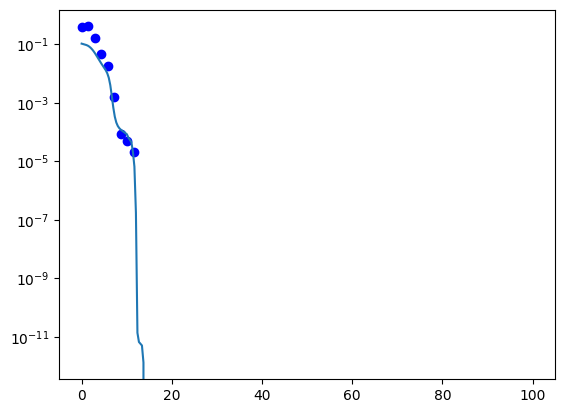

In [21]:
plt.plot(rt_radius_LT, rt_sb_t_LT/np.sum(rt_sb_t_LT),'bo')
plt.yscale('log')
plt.plot(p_radius_LT, sb_LT /np.sum(sb_LT))

In [22]:
def vout_make_parameter(v_out, v_emit ,v_rand):
    for ii in v_out:
        nn = int(ii / 100)
        globals()['RT_radius_vout_{}'.format(nn)] , globals()['RT_radius_kpc_vout_{}'.format(nn)], globals()['RT_SB_vout_{}'.format(nn)] = RT_make_parameter(ii, v_emit, v_rand,'CIV')[:3]
    return print("Make data!!")


def vemit_make_parameter(v_out, v_emit ,v_rand):
    for ii , jj in enumerate (v_emit):
        nn = int(jj / 10)
        globals()['RT_radius_vemit_{}'.format(nn)] , globals()['RT_radius_kpc_vemit_{}'.format(nn)], globals()['RT_SB_vemit_{}'.format(nn)] = RT_make_parameter(v_out, jj, v_rand,'CIV')[:3]
    return print("Make data!!")


def vrand_make_parameter(v_out, v_emit ,v_rand):
    for ii , jj in enumerate(v_rand):
        nn = int(jj / 10)
        globals()['RT_radius_vrand_{}'.format(nn)] , globals()['RT_radius_kpc_vrand_{}'.format(nn)], globals()['RT_SB_vrand_{}'.format(nn)] = RT_make_parameter(v_out, v_emit, jj,'CIV')[:3]
    return print("Make data!!")


# def efficient(z, radius_kpc,SB, total_Lum):
#     r_min, r_max = radius_kpc.min(), radius_kpc.max()  
#     # N = len(rt_radius)     z,
#     # Project_R = np.copy(rt_radius)
#     N = len(radius_kpc)

#     Lumin = np.zeros(N)
#     T_Lumin = np.zeros(N)
#     dR_pro = radius_kpc[1] - radius_kpc[0] 
#     for ii, bb in enumerate(radius_kpc):
#         Lumin[ii] = 2*np.pi*bb*SB[ii] * dR_pro * (1+z)**4

#     eff = total_Lum / np.sum(Lumin)
#     return eff



In [23]:
outflow = [0,200,300,400,600,800,1000]
emit = [0,1,50,100]
random = [11.8,50,100,200,300]
atom = ['CIV','HeII','Lya']

In [24]:
cloudy_radius_Lya ,cloudy_SB_Lya =RT_make_parameter(0,0,0,'Lya')[-2:]
cloudy_radius_HeII ,cloudy_SB_HeII =RT_make_parameter(0,0,0,'HeII')[-2:]
cloudy_radius_CIV ,cloudy_SB_CIV =RT_make_parameter(0,0,0,'CIV')[-2:]

make parameters of v_rand = 0 km/s, v_exp = 0 km/s, v_emit = 0 km/s for Lya
make parameters of v_rand = 0 km/s, v_exp = 0 km/s, v_emit = 0 km/s for HeII
make parameters of v_rand = 0 km/s, v_exp = 0 km/s, v_emit = 0 km/s for CIV


In [25]:
vout = np.array([0,200,300,400,600,800])
vemit = 50
vrand = 11.8
vout_make_parameter(vout,vemit,vrand)

make parameters of v_rand = 11.8 km/s, v_exp = 0 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 200 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 300 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 400 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 600 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 800 km/s, v_emit = 50 km/s for CIV
Make data!!


1.5600908033499194e+40 1.5578665190756982e+40


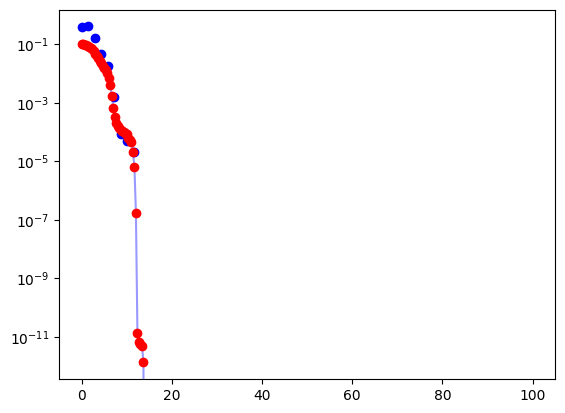

In [26]:
plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV/np.sum(cloudy_SB_CIV),'b-',alpha = 0.4,label=' CIV_CLoudy')

# plt.plot(p_radius_LT, sb_LT / np.sum(sb_LT) )

normal = np.sum(rt_sb_t_LT)
# tt = (rt_sb_t_LT/ normal)[0] / (cloudy_SB_CIV/np.sum(cloudy_SB_CIV))[0]

plt.plot(rt_radius_LT ,rt_sb_t_LT/ normal,'bo', label='w/o scattering')
plt.yscale('log')
# plt.xlim(-0.5,20)

aa ,bb, cc  = SB(0,radius_kpc_LT,civ_emis_LT,dr_LT)
print(np.sum(cc), civ_lum_LT )
normal = np.sum(bb)
plt.plot(aa,bb/normal,'ro')



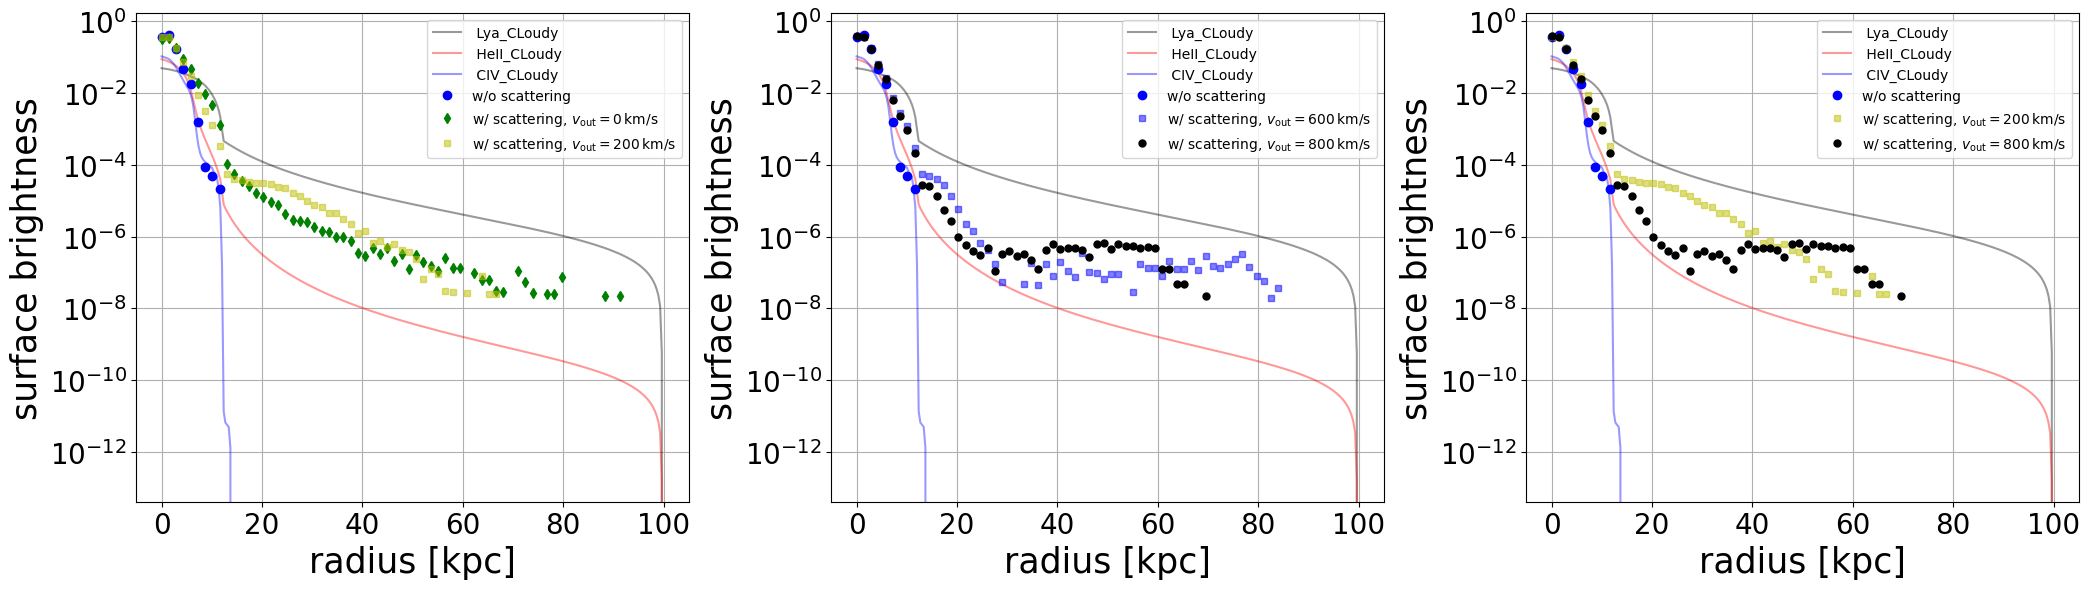

In [27]:
fig = plt.figure(1,figsize=(21,6))


plt.subplot(131)
plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya / np.sum(cloudy_SB_Lya),'k-',alpha = 0.4,label=' Lya_CLoudy')
plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII/np.sum(cloudy_SB_HeII),'r-',alpha = 0.4,label=' HeII_CLoudy')
plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV/np.sum(cloudy_SB_CIV),'b-',alpha = 0.4,label=' CIV_CLoudy')

normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT ,rt_sb_t_LT/ normal,'bo', label='w/o scattering')
plt.plot(RT_radius_vout_0 ,RT_SB_vout_0,'gd',ms=5,label=r'w/ scattering, $v_{\rm out} = 0 \, \rm km/s$')
plt.plot(RT_radius_vout_2 ,RT_SB_vout_2,'ys',ms=5, alpha = 0.5, label=r'w/ scattering, $v_{\rm out} = 200 \, \rm km/s$')
# plt.plot(RT_radius_6 ,RT_SB_6,'b*', label=r'w/ scattering, $v_{\rm out} = 600 km/s$')


# plt.xlim(0,15)

plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()


plt.subplot(132)
plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya / np.sum(cloudy_SB_Lya),'k-',alpha = 0.4,label=' Lya_CLoudy')
plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII/np.sum(cloudy_SB_HeII),'r-',alpha = 0.4,label=' HeII_CLoudy')
plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV/np.sum(cloudy_SB_CIV),'b-',alpha = 0.4,label=' CIV_CLoudy')

normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT ,rt_sb_t_LT/ normal,'bo', label='w/o scattering')
# plt.plot(RT_radius_0 ,RT_SB_0,'bs', label=r'w/ scattering, $v_{\rm out} = 0 km/s$')
plt.plot(RT_radius_vout_6 ,RT_SB_vout_6,'bs',ms=5,alpha =0.5 ,label=r'w/ scattering, $v_{\rm out} = 600 \, \rm km/s$')
plt.plot(RT_radius_vout_8 ,RT_SB_vout_8,'ko', ms = 5,label=r'w/ scattering, $v_{\rm out} = 800 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()




plt.subplot(133)
plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya / np.sum(cloudy_SB_Lya),'k-',alpha = 0.4,label=' Lya_CLoudy')
plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII/np.sum(cloudy_SB_HeII),'r-',alpha = 0.4,label=' HeII_CLoudy')
plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV/np.sum(cloudy_SB_CIV),'b-',alpha = 0.4,label=' CIV_CLoudy')
normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT ,rt_sb_t_LT/ normal,'bo', label='w/o scattering')
# plt.plot(RT_radius_0 ,RT_SB_0,'bs', label=r'w/ scattering, $v_{\rm out} = 0 km/s$')
plt.plot(RT_radius_vout_2 ,RT_SB_vout_2,'ys',ms=5 ,alpha =0.5,label=r'w/ scattering, $v_{\rm out} = 200 \,  \rm km/s$')
plt.plot(RT_radius_vout_8 ,RT_SB_vout_8,'ko',ms=5, label=r'w/ scattering, $v_{\rm out} = 800 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()

In [28]:
vout = 300
vemit = np.array([1,50,100,200,300])
vrand = 11.8
vemit_make_parameter(vout,vemit,vrand)


make parameters of v_rand = 11.8 km/s, v_exp = 300 km/s, v_emit = 1 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 300 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 300 km/s, v_emit = 100 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 300 km/s, v_emit = 200 km/s for CIV
make parameters of v_rand = 11.8 km/s, v_exp = 300 km/s, v_emit = 300 km/s for CIV
Make data!!


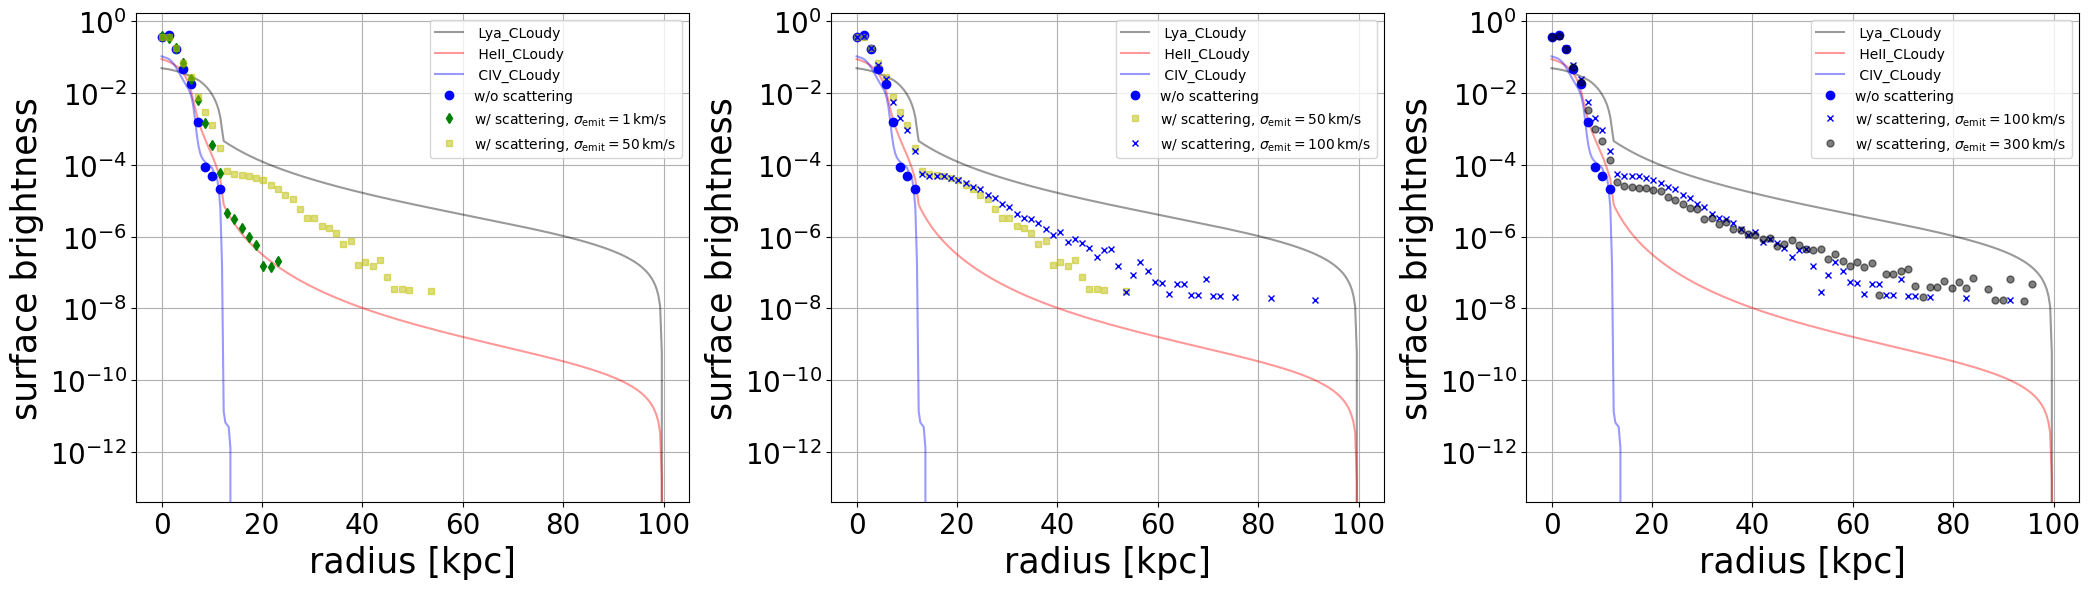

In [29]:
fig = plt.figure(1,figsize=(21,6))


plt.subplot(131)
plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya / np.sum(cloudy_SB_Lya),'k-',alpha = 0.4,label=' Lya_CLoudy')
plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII/np.sum(cloudy_SB_HeII),'r-',alpha = 0.4,label=' HeII_CLoudy')
plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV/np.sum(cloudy_SB_CIV),'b-',alpha = 0.4,label=' CIV_CLoudy')

normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT ,rt_sb_t_LT/ normal,'bo', label='w/o scattering')
plt.plot(RT_radius_vemit_0 ,RT_SB_vemit_0,'gd',ms=5,label=r'w/ scattering, $\sigma_{\rm emit} = 1 \, \rm km/s$')
plt.plot(RT_radius_vemit_5 ,RT_SB_vemit_5,'ys',ms=5, alpha = 0.5, label=r'w/ scattering, $\sigma_{\rm emit} = 50 \, \rm km/s$')
# plt.plot(RT_radius_6 ,RT_SB_6,'b*', label=r'w/ scattering, $v_{\rm out} = 600 km/s$')


# plt.xlim(0,15)

plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()


plt.subplot(132)
plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya / np.sum(cloudy_SB_Lya),'k-',alpha = 0.4,label=' Lya_CLoudy')
plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII/np.sum(cloudy_SB_HeII),'r-',alpha = 0.4,label=' HeII_CLoudy')
plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV/np.sum(cloudy_SB_CIV),'b-',alpha = 0.4,label=' CIV_CLoudy')

normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT ,rt_sb_t_LT/ normal,'bo', label='w/o scattering')
# plt.plot(RT_radius_0 ,RT_SB_0,'bs', label=r'w/ scattering, $v_{\rm out} = 0 km/s$')
plt.plot(RT_radius_vemit_5 ,RT_SB_vemit_5,'ys',ms=5,alpha =0.5 ,label=r'w/ scattering, $\sigma_{\rm emit} = 50 \, \rm km/s$')
plt.plot(RT_radius_vemit_10 ,RT_SB_vemit_10,'bx', ms = 5,label=r'w/ scattering, $\sigma_{\rm emit} = 100 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()




plt.subplot(133)
plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya / np.sum(cloudy_SB_Lya),'k-',alpha = 0.4,label=' Lya_CLoudy')
plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII/np.sum(cloudy_SB_HeII),'r-',alpha = 0.4,label=' HeII_CLoudy')
plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV/np.sum(cloudy_SB_CIV),'b-',alpha = 0.4,label=' CIV_CLoudy')
normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT ,rt_sb_t_LT/ normal,'bo', label='w/o scattering')
# plt.plot(RT_radius_0 ,RT_SB_0,'bs', label=r'w/ scattering, $v_{\rm out} = 0 km/s$')
plt.plot(RT_radius_vemit_10 ,RT_SB_vemit_10,'bx',ms=5,label=r'w/ scattering, $\sigma_{\rm emit} = 100 \,  \rm km/s$')
plt.plot(RT_radius_vemit_30 ,RT_SB_vemit_30,'ko',ms=5,alpha=0.5, label=r'w/ scattering, $\sigma_{\rm emit} = 300 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()

In [30]:
vout = 300
vemit = 50
vrand = np.array([11.8,50,100])
vrand_make_parameter(vout,vemit,vrand)


make parameters of v_rand = 11.8 km/s, v_exp = 300 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 50.0 km/s, v_exp = 300 km/s, v_emit = 50 km/s for CIV
make parameters of v_rand = 100.0 km/s, v_exp = 300 km/s, v_emit = 50 km/s for CIV
Make data!!


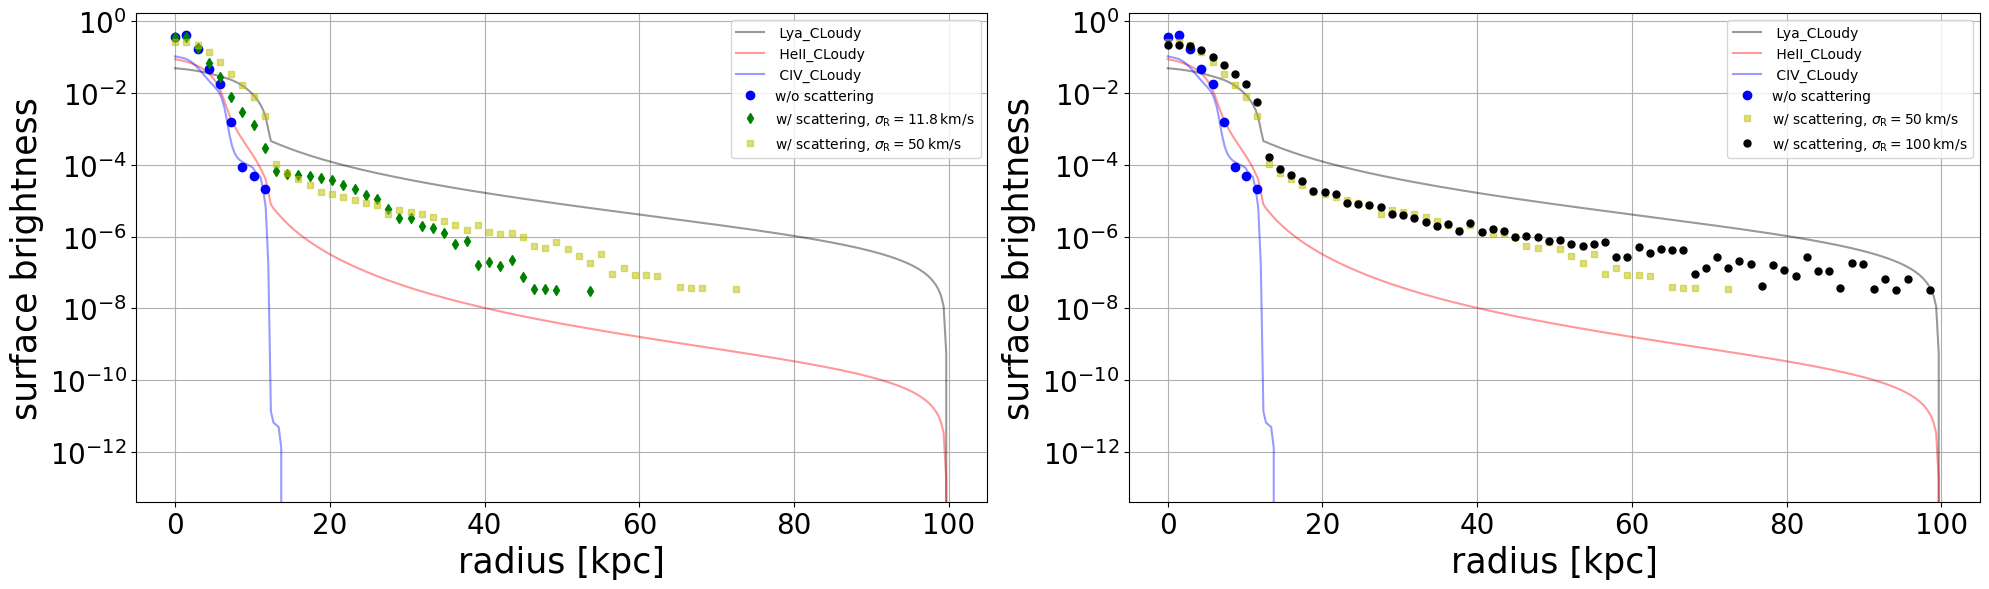

In [31]:
fig = plt.figure(1,figsize=(20,6))


plt.subplot(121)
plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya / np.sum(cloudy_SB_Lya),'k-',alpha = 0.4,label=' Lya_CLoudy')
plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII/np.sum(cloudy_SB_HeII),'r-',alpha = 0.4,label=' HeII_CLoudy')
plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV/np.sum(cloudy_SB_CIV),'b-',alpha = 0.4,label=' CIV_CLoudy')

normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT ,rt_sb_t_LT/ normal,'bo', label='w/o scattering')
plt.plot(RT_radius_vrand_1 ,RT_SB_vrand_1,'gd',ms=5,label=r'w/ scattering, $\sigma_{\rm R} = 11.8 \, \rm km/s$')
plt.plot(RT_radius_vrand_5 ,RT_SB_vrand_5,'ys',ms=5, alpha = 0.5, label=r'w/ scattering, $\sigma_{\rm R} = 50 \, \rm km/s$')
# plt.plot(RT_radius_6 ,RT_SB_6,'b*', label=r'w/ scattering, $v_{\rm out} = 600 km/s$')


# plt.xlim(0,15)

plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()


plt.subplot(122)
plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya / np.sum(cloudy_SB_Lya),'k-',alpha = 0.4,label=' Lya_CLoudy')
plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII/np.sum(cloudy_SB_HeII),'r-',alpha = 0.4,label=' HeII_CLoudy')
plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV/np.sum(cloudy_SB_CIV),'b-',alpha = 0.4,label=' CIV_CLoudy')

normal = np.sum(rt_sb_t_LT)
plt.plot(rt_radius_LT ,rt_sb_t_LT/ normal,'bo', label='w/o scattering')
# plt.plot(RT_radius_0 ,RT_SB_0,'bs', label=r'w/ scattering, $v_{\rm out} = 0 km/s$')
plt.plot(RT_radius_vrand_5 ,RT_SB_vrand_5,'ys',ms=5,alpha =0.5 ,label=r'w/ scattering, $\sigma_{\rm R} = 50 \, \rm km/s$')
plt.plot(RT_radius_vrand_10 ,RT_SB_vrand_10,'ko', ms = 5,label=r'w/ scattering, $\sigma_{\rm R} = 100 \, \rm km/s$')



plt.grid(True)
plt.yscale('log')
plt.xlabel('radius [kpc]',fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('surface brightness',fontsize=25)
plt.yticks(fontsize=20)
plt.legend()
plt.tight_layout()

# plt.title()



In [32]:
eff = efficient(0, rt_radius_LT ,rt_sb_t_LT,civ_lum_LT)
print(np.sum(lum_sb_LT) , civ_lum_LT )

NameError: name 'efficient' is not defined

In [211]:
# fig = plt.figure(1,figsize=(21,6))


# plt.subplot(131)
# plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya,'k-',alpha = 0.4,label=' Lya_CLoudy')
# plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII,'r-',alpha = 0.4,label=' HeII_CLoudy')
# plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV,'b-',alpha = 0.4,label=' CIV_CLoudy')

# eff = cloudy_SB_CIV.max() / rt_sb_t_LT.max()
# plt.plot(rt_radius_LT ,rt_sb_t_LT * eff,'bo', label='w/o scattering')

# eff = efficient(0, RT_radius_kpc_vout_0,RT_SB_vout_0,civ_lum_LT)
# plt.plot(RT_radius_vout_0 ,RT_SB_vout_0 * eff,'gd',ms=5,label=r'w/ scattering, $v_{\rm out} = 0 \, \rm km/s$')

# eff = efficient(0, RT_radius_kpc_vout_2,RT_SB_vout_2,civ_lum_LT)
# plt.plot(RT_radius_vout_2 ,RT_SB_vout_2*eff,'ys',ms=5, alpha = 0.5, label=r'w/ scattering, $v_{\rm out} = 200 \, \rm km/s$')
# # plt.plot(RT_radius_6 ,RT_SB_6,'b*', label=r'w/ scattering, $v_{\rm out} = 600 km/s$')


# # plt.xlim(0,15)

# plt.grid(True)
# plt.yscale('log')
# plt.xlabel('radius [kpc]',fontsize=25)
# plt.xticks(fontsize=20)
# plt.ylabel('surface brightness',fontsize=25)
# plt.yticks(fontsize=20)
# plt.legend()
# plt.tight_layout()


# plt.subplot(132)
# plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya,'k-',alpha = 0.4,label=' Lya_CLoudy')
# plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII,'r-',alpha = 0.4,label=' HeII_CLoudy')
# plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV,'b-',alpha = 0.4,label=' CIV_CLoudy')

# eff = cloudy_SB_CIV.max() / rt_sb_t_LT.max()
# plt.plot(rt_radius_LT ,rt_sb_t_LT * eff,'bo', label='w/o scattering')

# eff = efficient(0, RT_radius_kpc_vout_6,RT_SB_vout_6,civ_lum_LT)
# plt.plot(RT_radius_vout_6 ,RT_SB_vout_6 *eff,'gd',ms=5,alpha =0.5 ,label=r'w/ scattering, $v_{\rm out} = 600 \, \rm km/s$')

# eff = efficient(0, RT_radius_kpc_vout_8,RT_SB_vout_8,civ_lum_LT)
# plt.plot(RT_radius_vout_8 ,RT_SB_vout_8*eff,'ys', ms = 5,label=r'w/ scattering, $v_{\rm out} = 800 \, \rm km/s$')



# plt.grid(True)
# plt.yscale('log')
# plt.xlabel('radius [kpc]',fontsize=25)
# plt.xticks(fontsize=20)
# plt.ylabel('surface brightness',fontsize=25)
# plt.yticks(fontsize=20)
# plt.legend()
# plt.tight_layout()




# plt.subplot(133)
# plt.plot(cloudy_radius_Lya ,cloudy_SB_Lya,'k-',alpha = 0.4,label=' Lya_CLoudy')
# plt.plot(cloudy_radius_HeII ,cloudy_SB_HeII,'r-',alpha = 0.4,label=' HeII_CLoudy')
# plt.plot(cloudy_radius_CIV ,cloudy_SB_CIV,'b-',alpha = 0.4,label=' CIV_CLoudy')
# normal = np.sum(rt_sb_t_LT)
# eff = cloudy_SB_CIV.max() / rt_sb_t_LT.max()
# plt.plot(rt_radius_LT ,rt_sb_t_LT * eff,'bo', label='w/o scattering')
# # plt.plot(RT_radius_0 ,RT_SB_0,'bs', label=r'w/ scattering, $v_{\rm out} = 0 km/s$')
# eff = efficient(0, RT_radius_kpc_vout_2,RT_SB_vout_2,civ_lum_LT)
# plt.plot(RT_radius_vout_2 ,RT_SB_vout_2*eff,'gd',ms=5,alpha =0.5 ,label=r'w/ scattering, $v_{\rm out} = 200 \,  \rm km/s$')

# eff = efficient(0, RT_radius_kpc_vout_8,RT_SB_vout_8,civ_lum_LT)
# plt.plot(RT_radius_vout_8 ,RT_SB_vout_8 *eff,'ys',ms=5, label=r'w/ scattering, $v_{\rm out} = 800 \, \rm km/s$')



# plt.grid(True)
# plt.yscale('log')
# plt.xlabel('radius [kpc]',fontsize=25)
# plt.xticks(fontsize=20)
# plt.ylabel('surface brightness',fontsize=25)
# plt.yticks(fontsize=20)
# plt.legend()
# plt.tight_layout()